### Цирулев Н.В. М8О-408Б-22
# Лабораторная работа №1 (Проведение исследований с алгоритмом KNN)


## Задача классификации
PhiUSIIL Phishing URL Dataset решает практическую задачу кибербезопасности — автоматическую детекцию фишинговых URL, которые используются для кражи логинов/паролей, банковских данных и иных персональных данных. Такая классификация востребована в реальных системах защиты: почтовые фильтры, браузерные предупреждения, антифрод в банках, SIEM/IDS, мониторинг корпоративного трафика.
Классы: phishing vs legitimate, то есть модель учится отличать опасные ссылки от нормальных.

Начальные условия: целевая переменная + train/test split
В датасете `label=1` — legitimate, `label=0` — phishing.
Для метрик считаем “позитивный” класс = phishing: `y=1` → phishing.

In [8]:
import kagglehub
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

RANDOM_STATE = 42
TEST_SIZE = 0.2

TUNE_N = 20000
CV_SPLITS = 2

SCRATCH_BATCH = 128

path = kagglehub.dataset_download("ndarvind/phiusiil-phishing-url-dataset")
root = Path(path)
csv_path = max(root.rglob("*.csv"), key=lambda p: p.stat().st_size)

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()


# Начальные условия: целевая переменная + train/test split

y = (df["label"] == 0).astype(int)
X = df.drop(columns=["label"])

text_cols = [c for c in ["URL", "Domain", "TLD", "Title"] if c in X.columns]
num_cols = [c for c in X.columns if c not in text_cols]

print("Numeric features:", len(num_cols))
print("Dropped text cols:", text_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Shape: (235795, 55)
Numeric features: 50
Dropped text cols: ['URL', 'Domain', 'TLD', 'Title']
Train: (188636, 54) Test: (47159, 54)


### Метрики качества и обоснование
Выбраны метрики для класса phishing (y=1):
- **Recall**: важно минимизировать пропуск фишинга (False Negative).
- **Precision**: важно минимизировать ложные тревоги (False Positive).
- **F1**: компромисс между precision и recall одной цифрой.


=== Baseline sklearn KNN (no scaling, k=5, uniform) ===
precision: 0.999056
recall:    0.995542
f1:        0.997296


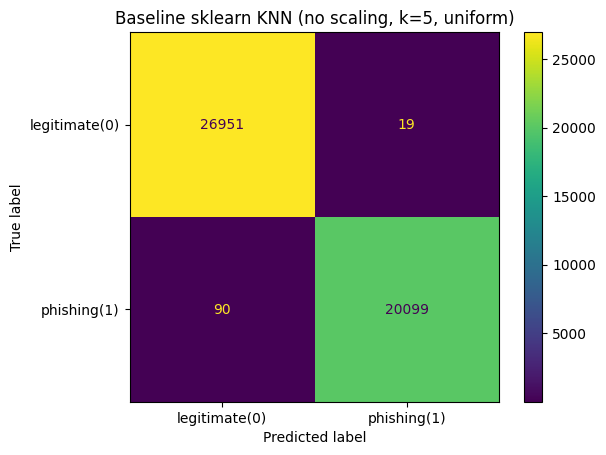

In [9]:
def eval_clf(y_true, y_pred, title: str):
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall    = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1        = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    print(f"\n=== {title} ===")
    print(f"precision: {precision:.6f}")
    print(f"recall:    {recall:.6f}")
    print(f"f1:        {f1:.6f}")

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=["legitimate(0)", "phishing(1)"]).plot(values_format="d")
    plt.title(title)
    plt.show()

    return {"precision": precision, "recall": recall, "f1": f1}

# Создание бейзлайна и оценка качества (sklearn)
X_train_num = X_train[num_cols].to_numpy(dtype=np.float32)
X_test_num  = X_test[num_cols].to_numpy(dtype=np.float32)

knn_baseline = KNeighborsClassifier(
    n_neighbors=5,
    weights="uniform",
    p=2,
    algorithm="brute",
    n_jobs=-1
)
knn_baseline.fit(X_train_num, y_train)

y_pred_baseline = knn_baseline.predict(X_test_num)
baseline_sklearn_metrics = eval_clf(y_test, y_pred_baseline, "Baseline sklearn KNN (no scaling, k=5, uniform)")

### Улучшение бейзлайна (гипотезы → проверка → improved)
**Гипотезы:**
1) StandardScaler улучшит качество (KNN основан на расстояниях, масштаб признаков влияет).
2) Подбор `k` и `weights` на кросс-валидации улучшит качество.

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best params: {'knn__n_neighbors': 3, 'knn__weights': 'distance'}

=== Improved sklearn KNN (scaling + tuned k/weights) ===
precision: 0.999603
recall:    0.997920
f1:        0.998761


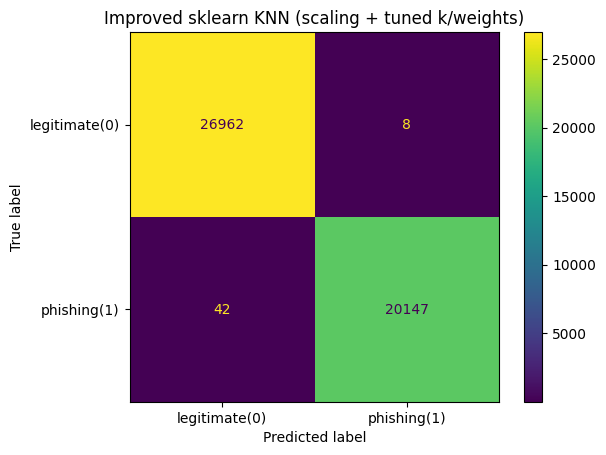

,precision,recall,f1
baseline_sklearn,0.999056,0.995542,0.997296
improved_sklearn,0.999603,0.997920,0.998761



ΔF1 (improved - baseline): 0.0014649032585278832


In [10]:
X_tune, _, y_tune, _ = train_test_split(
    X_train[num_cols], y_train,
    train_size=TUNE_N,
    stratify=y_train,
    random_state=RANDOM_STATE
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(p=2, algorithm="brute", n_jobs=1))
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 11, 21],
    "knn__weights": ["uniform", "distance"]
}

cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1",
    refit=True,
    cv=cv,
    n_jobs=-1,
    verbose=2
)
search.fit(X_tune, y_tune)

print("Best params:", search.best_params_)

best_model = search.best_estimator_
best_model.fit(X_train[num_cols], y_train)

y_pred_improved = best_model.predict(X_test[num_cols])
improved_sklearn_metrics = eval_clf(y_test, y_pred_improved, "Improved sklearn KNN (scaling + tuned k/weights)")

# Сравнение baseline vs improved и вывод
compare_2_vs_3 = pd.DataFrame(
    [baseline_sklearn_metrics, improved_sklearn_metrics],
    index=["baseline_sklearn", "improved_sklearn"]
)
display(compare_2_vs_3)

print("\nΔF1 (improved - baseline):",
      improved_sklearn_metrics["f1"] - baseline_sklearn_metrics["f1"])

scratch predict: batch 50/369
scratch predict: batch 100/369
scratch predict: batch 150/369
scratch predict: batch 200/369
scratch predict: batch 250/369
scratch predict: batch 300/369
scratch predict: batch 350/369
scratch predict: batch 369/369

=== Baseline scratch KNN (no scaling, k=5, uniform) ===
precision: 0.999056
recall:    0.995542
f1:        0.997296


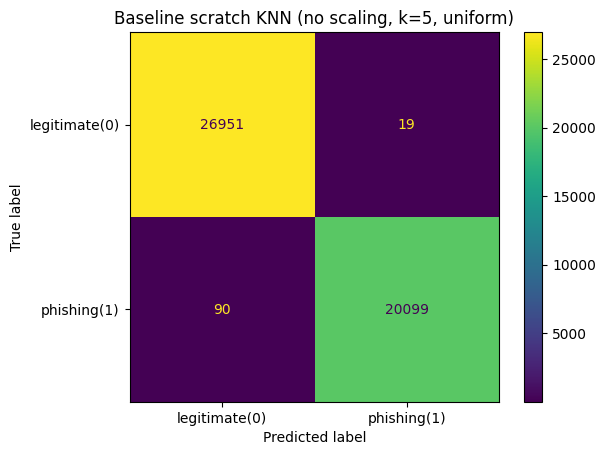


Agreement (baseline scratch vs baseline sklearn): 1.0


In [11]:
# Имплементация алгоритма (KNN scratch) + оценка
class KNNClassifierScratch:
    def __init__(self, n_neighbors=5, weights="uniform", batch_size=128, eps=1e-9, verbose=False):
        assert weights in ("uniform", "distance")
        self.k = int(n_neighbors)
        self.weights = weights
        self.batch_size = int(batch_size)
        self.eps = float(eps)
        self.verbose = bool(verbose)

        self.Xt = None
        self.yt = None
        self.train_sq = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        X = np.ascontiguousarray(X)
        self.Xt = X
        self.yt = np.asarray(y, dtype=np.int32)
        self.train_sq = np.sum(self.Xt * self.Xt, axis=1).astype(np.float32)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        X = np.ascontiguousarray(X)

        n_test = X.shape[0]
        preds = np.zeros(n_test, dtype=np.int32)

        step = self.batch_size
        total_batches = (n_test + step - 1) // step

        for b, start in enumerate(range(0, n_test, step), start=1):
            end = min(start + step, n_test)
            Xb = X[start:end]

            test_sq = np.sum(Xb * Xb, axis=1, keepdims=True).astype(np.float32)
            dist2 = test_sq + self.train_sq[None, :] - 2.0 * (Xb @ self.Xt.T)
            dist2 = np.maximum(dist2, 0.0)

            nn_idx = np.argpartition(dist2, kth=self.k - 1, axis=1)[:, : self.k]
            nn_y = self.yt[nn_idx]

            if self.weights == "uniform":
                p1 = nn_y.mean(axis=1)
            else:
                nn_dist = np.sqrt(np.take_along_axis(dist2, nn_idx, axis=1)).astype(np.float32)
                w = 1.0 / (nn_dist + self.eps)
                p1 = (w * nn_y).sum(axis=1) / w.sum(axis=1)

            preds[start:end] = (p1 >= 0.5).astype(np.int32)

            if self.verbose and (b % 50 == 0 or b == total_batches):
                print(f"scratch predict: batch {b}/{total_batches}")

        return preds

scratch_baseline = KNNClassifierScratch(
    n_neighbors=5,
    weights="uniform",
    batch_size=SCRATCH_BATCH,
    verbose=True
)
scratch_baseline.fit(X_train_num, y_train)

y_pred_scratch_baseline = scratch_baseline.predict(X_test_num)
baseline_scratch_metrics = eval_clf(y_test, y_pred_scratch_baseline, "Baseline scratch KNN (no scaling, k=5, uniform)")

print("\nAgreement (baseline scratch vs baseline sklearn):",
      (y_pred_scratch_baseline == y_pred_baseline).mean())

scratch predict: batch 50/369
scratch predict: batch 100/369
scratch predict: batch 150/369
scratch predict: batch 200/369
scratch predict: batch 250/369
scratch predict: batch 300/369
scratch predict: batch 350/369
scratch predict: batch 369/369

=== Improved scratch KNN (scaling + tuned: k=3, w=distance) ===
precision: 0.999603
recall:    0.997920
f1:        0.998761


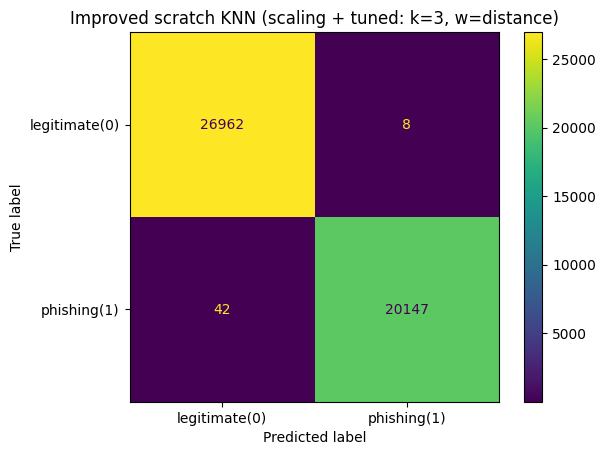


Agreement (improved scratch vs improved sklearn): 1.0


In [12]:
# Scratch improved (техники из улучшенного бейзлайна)
best_k = search.best_params_["knn__n_neighbors"]
best_w = search.best_params_["knn__weights"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num).astype(np.float32)
X_test_scaled  = scaler.transform(X_test_num).astype(np.float32)

scratch_improved = KNNClassifierScratch(
    n_neighbors=best_k,
    weights=best_w,
    batch_size=SCRATCH_BATCH,
    verbose=True
)
scratch_improved.fit(X_train_scaled, y_train)

y_pred_scratch_improved = scratch_improved.predict(X_test_scaled)
improved_scratch_metrics = eval_clf(
    y_test,
    y_pred_scratch_improved,
    f"Improved scratch KNN (scaling + tuned: k={best_k}, w={best_w})"
)

print("\nAgreement (improved scratch vs improved sklearn):",
      (y_pred_scratch_improved == y_pred_improved).mean())

In [13]:
# Итоговое сравнение и выводы
final_compare = pd.DataFrame(
    [baseline_sklearn_metrics, improved_sklearn_metrics, baseline_scratch_metrics, improved_scratch_metrics],
    index=["baseline_sklearn", "improved_sklearn", "baseline_scratch", "improved_scratch"]
)
display(final_compare)

print("\nΔF1 sklearn (improved - baseline):",
      improved_sklearn_metrics["f1"] - baseline_sklearn_metrics["f1"])
print("ΔF1 scratch (improved - baseline):",
      improved_scratch_metrics["f1"] - baseline_scratch_metrics["f1"])

,precision,recall,f1
baseline_sklearn,0.999056,0.995542,0.997296
improved_sklearn,0.999603,0.997920,0.998761
baseline_scratch,0.999056,0.995542,0.997296
improved_scratch,0.999603,0.997920,0.998761



ΔF1 sklearn (improved - baseline): 0.0014649032585278832
ΔF1 scratch (improved - baseline): 0.0014649032585278832


### Итоговые выводы по классификации
**1) Сравнение бейзлайна и улучшенной модели (sklearn).**  
Улучшенный KNN (StandardScaler + подбор `k` и `weights`) показал прирост по всем выбранным метрикам относительно бейзлайна:
- precision: 0.999056 → 0.999603  
- recall: 0.995542 → 0.997920  
- f1: 0.997296 → 0.998761  
Прирост F1 составил **ΔF1 ≈ 0.001465**, т.е. гипотезы о полезности масштабирования и подбора гиперпараметров для KNN подтвердились.

**2) Корректность имплементации (scratch).**  
Метрики `baseline_scratch` полностью совпали с `baseline_sklearn`, а `improved_scratch` — с `improved_sklearn`.  
Дополнительно, совпадение предсказаний улучшенных моделей составило **Agreement = 1.0**, что подтверждает: реализация KNN “с нуля” корректно воспроизводит библиотечный алгоритм при одинаковых настройках.

**3) Почему на этом датасете такие высокие результаты.**  
Высокие значения метрик (почти 1.0) объясняются свойствами датасета:
- В данных уже есть сильные инженерные признаки, извлечённые из URL и исходного кода страницы.
- Фишинговые URL имеют характерные паттерны (обфускация, спецсимволы, редиректы и т.п.), что даёт “резкую” границу классов.
- В таком пространстве признаков классы образуют кластеры, и правило ближайших соседей работает почти идеально.

**Итог:** задача классификации на данном наборе признаков хорошо решается KNN; улучшения через scaling и подбор гиперпараметров дают небольшой, но устойчивый прирост качества.

## Задача регрессии
Laptop Prices Dataset решает практическую задачу регрессии: прогнозирование цены ноутбука по его характеристикам (бренд, CPU, поколение, RAM, тип памяти, SSD/HDD, ОС, видеопамять, вес/категория, гарантия, рейтинг и т.п.). Такая модель полезна для ценообразования и аналитики в e-commerce, оценки конкурентоспособности товаров, автоматического формирования “справедливой цены”, выявления аномально завышенных/заниженных предложений, а также для рекомендательных систем (например, подбирать варианты в бюджет пользователя или искать наиболее выгодные конфигурации).

In [ ]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

RANDOM_STATE = 42
TEST_SIZE = 0.2

TUNE_N = 500
CV_SPLITS = 3

SCRATCH_BATCH = 128

import kagglehub
path2 = kagglehub.dataset_download("anubhavgoyal10/laptop-prices-dataset")
root2 = Path(path2)
csv_path2 = max(root.rglob("*.csv"), key=lambda p: p.stat().st_size)
df2 = pd.read_csv(csv_path2)
df2.columns = df2.columns.str.strip()

print("Shape:", df2.shape)
df2.head()

# Целевая переменная: Price
def parse_number(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan

def clean_laptop(df_in: pd.DataFrame) -> pd.DataFrame:
    dfc = df_in.copy()
    dfc.columns = dfc.columns.str.strip()

    for col in ["ram_gb", "ssd", "hdd", "graphic_card_gb", "os_bit", "rating", "processor_gnrtn"]:
        if col in dfc.columns:
            dfc[col] = dfc[col].map(parse_number)

    dfc["Price"] = pd.to_numeric(dfc["Price"], errors="coerce")
    for col in ["Number of Ratings", "Number of Reviews"]:
        if col in dfc.columns:
            dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

    return dfc

dfc = clean_laptop(df2)

y = dfc["Price"].astype(float)
X = dfc.drop(columns=["Price"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Shape: (823, 19)
Train: (658, 18) Test: (165, 18)


### Метрики качества и обоснование
Выбраны метрики регрессии:
- **MAE** (mean absolute error): средняя ошибка в тех же единицах, что и цена → интерпретируемо (в валюте датасета).
- **RMSE** (root mean squared error): сильнее штрафует большие ошибки → важно избегать крупных промахов по цене.
- **R²**: показывает долю объяснённой дисперсии (качество “в целом” относительно среднего предсказания).

In [23]:
def eval_reg(y_true, y_pred, title: str):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {title} ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R2:   {r2:.5f}")

    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [24]:
# Создание бейзлайна и оценка качества
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if c not in num_cols]

prep_baseline = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ],
    remainder="drop"
)

Xtr_base = prep_baseline.fit_transform(X_train)
Xte_base = prep_baseline.transform(X_test)

Xtr_base = np.asarray(Xtr_base, dtype=np.float32)
Xte_base = np.asarray(Xte_base, dtype=np.float32)

knn_baseline = KNeighborsRegressor(
    n_neighbors=5,
    weights="uniform",
    p=2,
    algorithm="brute",
    n_jobs=-1
)
knn_baseline.fit(Xtr_base, y_train)

pred_base = knn_baseline.predict(Xte_base)
baseline_sklearn_metrics = eval_reg(y_test, pred_base, "Baseline sklearn KNNRegressor (no scaling, k=5, uniform)")


=== Baseline sklearn KNNRegressor (no scaling, k=5, uniform) ===
MAE:  22184.656
RMSE: 34194.148
R2:   0.40002


### Улучшение бейзлайна (гипотезы → проверка → improved)
**Гипотезы (по заданию):**
1) StandardScaler для числовых признаков улучшит качество (KNN основан на расстояниях).
2) Подбор `k` и `weights` по кросс-валидации улучшит качество.

Проверяем гипотезы тюнингом на подвыборке train

In [25]:
tune_n = min(TUNE_N, len(X_train))
X_tune = X_train.sample(n=tune_n, random_state=RANDOM_STATE)
y_tune = y_train.loc[X_tune.index]

prep_improved = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ],
    remainder="drop"
)

pipe_tune = Pipeline([
    ("prep", prep_improved),
    ("knn", KNeighborsRegressor(p=2, algorithm="brute"))
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 11, 21, 31],
    "knn__weights": ["uniform", "distance"]
}

cv = KFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

search = GridSearchCV(
    pipe_tune,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    refit=True,
    cv=cv,
    n_jobs=-1,
    verbose=2
)
search.fit(X_tune, y_tune)

print("Best params:", search.best_params_)
best_k = search.best_params_["knn__n_neighbors"]
best_w = search.best_params_["knn__weights"]

prep_improved_full = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ],
    remainder="drop"
)

Xtr_impr = prep_improved_full.fit_transform(X_train)
Xte_impr = prep_improved_full.transform(X_test)

Xtr_impr = np.asarray(Xtr_impr, dtype=np.float32)
Xte_impr = np.asarray(Xte_impr, dtype=np.float32)

knn_improved = KNeighborsRegressor(
    n_neighbors=best_k,
    weights=best_w,
    p=2,
    algorithm="brute",
    n_jobs=-1
)
knn_improved.fit(Xtr_impr, y_train)

pred_impr = knn_improved.predict(Xte_impr)
improved_sklearn_metrics = eval_reg(
    y_test, pred_impr,
    f"Improved sklearn KNNRegressor (scaling + tuned: k={best_k}, w={best_w})"
)

compare_2_vs_3 = pd.DataFrame(
    [baseline_sklearn_metrics, improved_sklearn_metrics],
    index=["baseline_sklearn", "improved_sklearn"]
)
display(compare_2_vs_3)

print("\nΔMAE (improved - baseline):", improved_sklearn_metrics["MAE"] - baseline_sklearn_metrics["MAE"])
print("ΔRMSE (improved - baseline):", improved_sklearn_metrics["RMSE"] - baseline_sklearn_metrics["RMSE"])
print("ΔR2 (improved - baseline):", improved_sklearn_metrics["R2"] - baseline_sklearn_metrics["R2"])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'knn__n_neighbors': 3, 'knn__weights': 'distance'}

=== Improved sklearn KNNRegressor (scaling + tuned: k=3, w=distance) ===
MAE:  13450.772
RMSE: 25372.392
R2:   0.66967


,MAE,RMSE,R2
baseline_sklearn,22184.655758,34194.148377,0.400023
improved_sklearn,13450.772092,25372.392076,0.669665



ΔMAE (improved - baseline): -8733.883665391973
ΔRMSE (improved - baseline): -8821.756301045676
ΔR2 (improved - baseline): 0.2696426691168057


In [ ]:
# Имплементация алгоритма
class KNNRegressorScratch:
    def __init__(self, n_neighbors=5, weights="uniform", batch_size=128, verbose=False):
        assert weights in ("uniform", "distance")
        self.k = int(n_neighbors)
        self.weights = weights
        self.batch_size = int(batch_size)
        self.verbose = bool(verbose)

        self.Xt = None
        self.yt = None
        self.train_sq = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        X = np.ascontiguousarray(X)
        self.Xt = X
        self.yt = np.asarray(y, dtype=np.float64)
        self.train_sq = np.sum(self.Xt * self.Xt, axis=1)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        X = np.ascontiguousarray(X)

        n_test = X.shape[0]
        preds = np.zeros(n_test, dtype=np.float64)

        step = self.batch_size
        total_batches = (n_test + step - 1) // step

        for b, start in enumerate(range(0, n_test, step), start=1):
            end = min(start + step, n_test)
            Xb = X[start:end]

            test_sq = np.sum(Xb * Xb, axis=1, keepdims=True)
            dist2 = test_sq + self.train_sq[None, :] - 2.0 * (Xb @ self.Xt.T)
            dist2 = np.maximum(dist2, 0.0)

            nn_idx = np.argpartition(dist2, kth=self.k - 1, axis=1)[:, : self.k]
            nn_y = self.yt[nn_idx]

            if self.weights == "uniform":
                preds[start:end] = nn_y.mean(axis=1)
            else:
                nn_dist = np.sqrt(np.take_along_axis(dist2, nn_idx, axis=1))

                zero_mask = (nn_dist == 0)
                has_zero = zero_mask.any(axis=1)

                out = np.empty(end - start, dtype=np.float64)

                if has_zero.any():
                    idx0 = np.where(has_zero)[0]
                    out[idx0] = (nn_y[idx0] * zero_mask[idx0]).sum(axis=1) / zero_mask[idx0].sum(axis=1)

                idx1 = np.where(~has_zero)[0]
                if idx1.size:
                    w = 1.0 / nn_dist[idx1]
                    out[idx1] = (w * nn_y[idx1]).sum(axis=1) / w.sum(axis=1)

                preds[start:end] = out

            if self.verbose and (b % 10 == 0 or b == total_batches):
                print(f"scratch predict: batch {b}/{total_batches}")

        return preds

# Scratch baseline и сравнение со sklearn baseline
scratch_baseline = KNNRegressorScratch(
    n_neighbors=5,
    weights="uniform",
    batch_size=SCRATCH_BATCH,
    verbose=True
)
scratch_baseline.fit(Xtr_base, y_train)

pred_s_base = scratch_baseline.predict(Xte_base)
baseline_scratch_metrics = eval_reg(y_test, pred_s_base, "Baseline scratch KNNRegressor (k=5, uniform)")

print("\nMean |pred_scratch - pred_sklearn| (baseline):", np.mean(np.abs(pred_s_base - pred_base)))

scratch predict: batch 2/2

=== Baseline scratch KNNRegressor (k=5, uniform) ===
MAE:  22280.132
RMSE: 34301.199
R2:   0.39626

Mean |pred_scratch - pred_sklearn| (baseline): 383.8133333333333


In [27]:
# Добавим техники из улучшенного бейзлайна 
scratch_improved = KNNRegressorScratch(
    n_neighbors=best_k,
    weights=best_w,
    batch_size=SCRATCH_BATCH,
    verbose=True
)
scratch_improved.fit(Xtr_impr, y_train)

pred_s_impr = scratch_improved.predict(Xte_impr)
improved_scratch_metrics = eval_reg(
    y_test, pred_s_impr,
    f"Improved scratch KNNRegressor (scaling + tuned: k={best_k}, w={best_w})"
)

print("\nMean |pred_scratch - pred_sklearn| (improved):", np.mean(np.abs(pred_s_impr - pred_impr)))

scratch predict: batch 2/2

=== Improved scratch KNNRegressor (scaling + tuned: k=3, w=distance) ===
MAE:  13268.366
RMSE: 25201.392
R2:   0.67410

Mean |pred_scratch - pred_sklearn| (improved): 258.6386698986267


In [28]:
# Итоговое сравнение и выводы
final_compare = pd.DataFrame(
    [baseline_sklearn_metrics, improved_sklearn_metrics, baseline_scratch_metrics, improved_scratch_metrics],
    index=["baseline_sklearn", "improved_sklearn", "baseline_scratch", "improved_scratch"]
)
display(final_compare)

print("\nΔMAE sklearn (improved - baseline):", improved_sklearn_metrics["MAE"] - baseline_sklearn_metrics["MAE"])
print("ΔMAE scratch (improved - baseline):", improved_scratch_metrics["MAE"] - baseline_scratch_metrics["MAE"])

,MAE,RMSE,R2
baseline_sklearn,22184.655758,34194.148377,0.400023
improved_sklearn,13450.772092,25372.392076,0.669665
baseline_scratch,22280.132121,34301.199266,0.396260
improved_scratch,13268.366269,25201.391540,0.674103



ΔMAE sklearn (improved - baseline): -8733.883665391973
ΔMAE scratch (improved - baseline): -9011.765851910845


### Итоговые выводы по регрессии
1) Baseline vs improved (sklearn).  
После добавления StandardScaler для числовых признаков и подбора гиперпараметров (k, weights) качество заметно выросло:
- MAE: 22184.66 → 13450.77 (ошибка уменьшилась примерно на 8733.88)
- RMSE: 34194.15 → 25372.39 (крупные промахи стали реже)
- R2: 0.400 → 0.670 (модель стала объяснять существенно больше вариации цен)

Это подтверждает гипотезы, что для KNN важны масштабирование (из-за метрики расстояния) и корректный выбор числа соседей/взвешивания.

2) Корректность scratch-реализации.  
Результаты scratch близки к sklearn как на baseline, так и на improved:
- baseline_scratch практически совпадает по MAE/RMSE/R2 с baseline_sklearn
- improved_scratch также близок к improved_sklearn (R2 даже чуть выше: 0.674 vs 0.670)

Небольшие отличия объясняются деталями вычислений (округления, обработка нулевых расстояний, порядок операций), но поведение алгоритма воспроизводится корректно.

3) Итог.  
В регрессии улучшения дали сильный прирост: MAE и RMSE заметно снизились, R2 вырос до ~0.67. Значит, модель уже не “угадывает случайно”, а реально использует признаки для предсказания цены.
